<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

In [ ]:
# install dependencies:
!pip install pyyaml==5.1
!pip install Pillow==5.3.0
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
!gcc --version

In [ ]:
import torch, torchvision
import torch
assert torch.__version__.startswith("1.7")
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random, glob
from google.colab.patches import cv2_imshow
from os import listdir
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cannot detect lamp objects

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_2d9806.pkl: 431MB [00:35, 12.1MB/s]                           


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


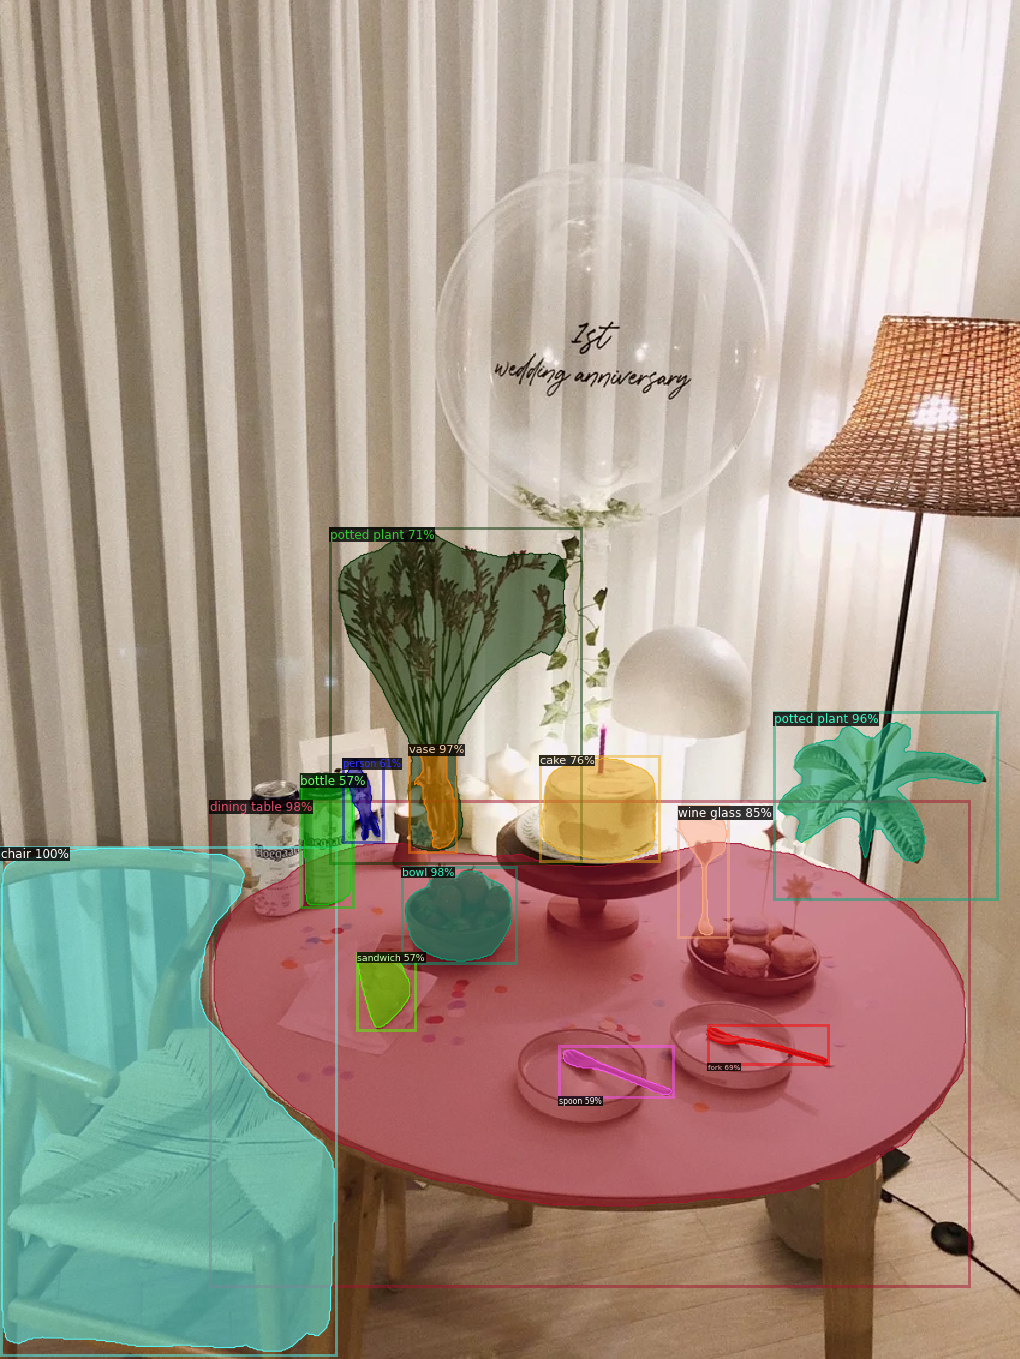

In [4]:
im2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/dl_project/test_img.jpg")

outputs2 = predictor(im2)
v2 = Visualizer(im2[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out2 = v2.draw_instance_predictions(outputs2["instances"].to("cpu"))
cv2_imshow(out2.get_image()[:, :, ::-1])

# Fine Tuning
 - Labelling more than 1k Lamp images in Roboflow.com

In [5]:
!curl -L "https://app.roboflow.com/ds/GzlANAXgjt?key=I8YM2dQw9C" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1043      0 --:--:-- --:--:-- --:--:--  1043
100 93.9M  100 93.9M    0     0  40.8M      0  0:00:02  0:00:02 --:--:--  137M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/room_23870_png.rf.1040217269086e82e9ac27c404cd593a.jpg  
 extracting: test/room_26549_png.rf.63496db81ae300917a421f2a020989a7.jpg  
 extracting: test/room_27360_png.rf.0de98301b6458ea951413c7d7000962f.jpg  
 extracting: test/room_27470_png.rf.aa7cc328b9f7058b28a2572fe2e35ccc.jpg  
 extracting: test/room_27688_png.rf.b79a4a4b2710d7a393b5bb66b1872c0c.jpg  
 extracting: test/room_28052_png.rf.fc8806b790a8f2ef203ea4dd9ac59431.jpg  
 extracting: test/room_28234_png.rf.80ff5530f864df98e69d3f31e21b4ea1.jpg  
 extracting: test/room_28868_png.rf.

## Register dataset

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

## Visualize training data

WARNING [02/16 02:13:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/16 02:13:25 d2.data.datasets.coco]: Loaded 1610 images in COCO format from /content/train/_annotations.coco.json


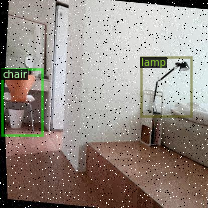

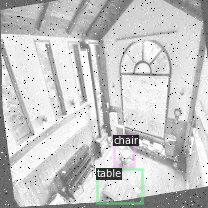

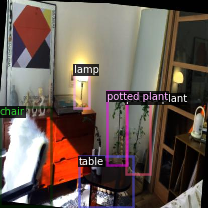

In [7]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train and evaluate our model

In [8]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [9]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 4000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7 #your number of classes + 1
cfg.MODEL.MASK_ON = False

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/16 02:13:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.


[02/16 02:13:32 d2.engine.train_loop]: Starting training from iteration 0
[02/16 02:13:45 d2.utils.events]:  eta: 0:42:56  iter: 19  total_loss: 3.321  loss_cls: 2.057  loss_box_reg: 0.8687  loss_rpn_cls: 0.2742  loss_rpn_loc: 0.04579  time: 0.6507  data_time: 0.0293  lr: 1.9981e-05  max_mem: 7666M
[02/16 02:13:58 d2.utils.events]:  eta: 0:42:41  iter: 39  total_loss: 2.739  loss_cls: 1.667  loss_box_reg: 0.9176  loss_rpn_cls: 0.1619  loss_rpn_loc: 0.03823  time: 0.6439  data_time: 0.0148  lr: 3.9961e-05  max_mem: 7666M
[02/16 02:14:11 d2.utils.events]:  eta: 0:42:31  iter: 59  total_loss: 2.242  loss_cls: 1.168  loss_box_reg: 0.9121  loss_rpn_cls: 0.09903  loss_rpn_loc: 0.0408  time: 0.6469  data_time: 0.0131  lr: 5.9941e-05  max_mem: 7666M
[02/16 02:14:24 d2.utils.events]:  eta: 0:42:22  iter: 79  total_loss: 2.017  loss_cls: 0.9577  loss_box_reg: 0.8931  loss_rpn_cls: 0.07396  loss_rpn_loc: 0.03889  time: 0.6480  data_time: 0.0176  lr: 7.9921e-05  max_mem: 7666M
[02/16 02:14:37 d2.u

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [11]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [02/16 02:59:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
WARNING [02/16 02:59:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/16 02:59:26 d2.data.datasets.coco]: Loaded 115 images in COCO format from /content/test/_annotations.coco.json
[02/16 02:59:26 d2.data.build]: Distribution of instances among all 7 categories:
|  category  | #instances   |  category  | #instances   |   category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:------------:|:-------------|
| floorstand | 0            |   chair    | 127          |    clock     | 17           |
|   couch    | 57           |    lamp    | 117          | potted plant | 129          |
|   table    | 74           |            |              |              |              |
|   total    | 521          |            |              |           

OrderedDict([('bbox',
              {'AP': 43.565721595259696,
               'AP-chair': 50.06237283859212,
               'AP-clock': 27.160896060462708,
               'AP-couch': 61.05042068975565,
               'AP-floorstand': nan,
               'AP-lamp': 37.66437130677049,
               'AP-potted plant': 38.401215690575654,
               'AP-table': 47.05505298540155,
               'AP50': 73.4681551978202,
               'AP75': 47.525571402565646,
               'APl': 52.54558397732778,
               'APm': 45.111535419013606,
               'APs': 15.101754874923934})])

In [12]:
%ls ./output/

coco_instances_results.json                        last_checkpoint
events.out.tfevents.1613441609.ece0a0bf9a65.138.0  metrics.json
instances_predictions.pth                          model_final.pth


In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )   
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


# Sample
 - Detect 2 table lamps but one of those is a balloon :(
 - Miss 1 stand lamp
 - Need more work

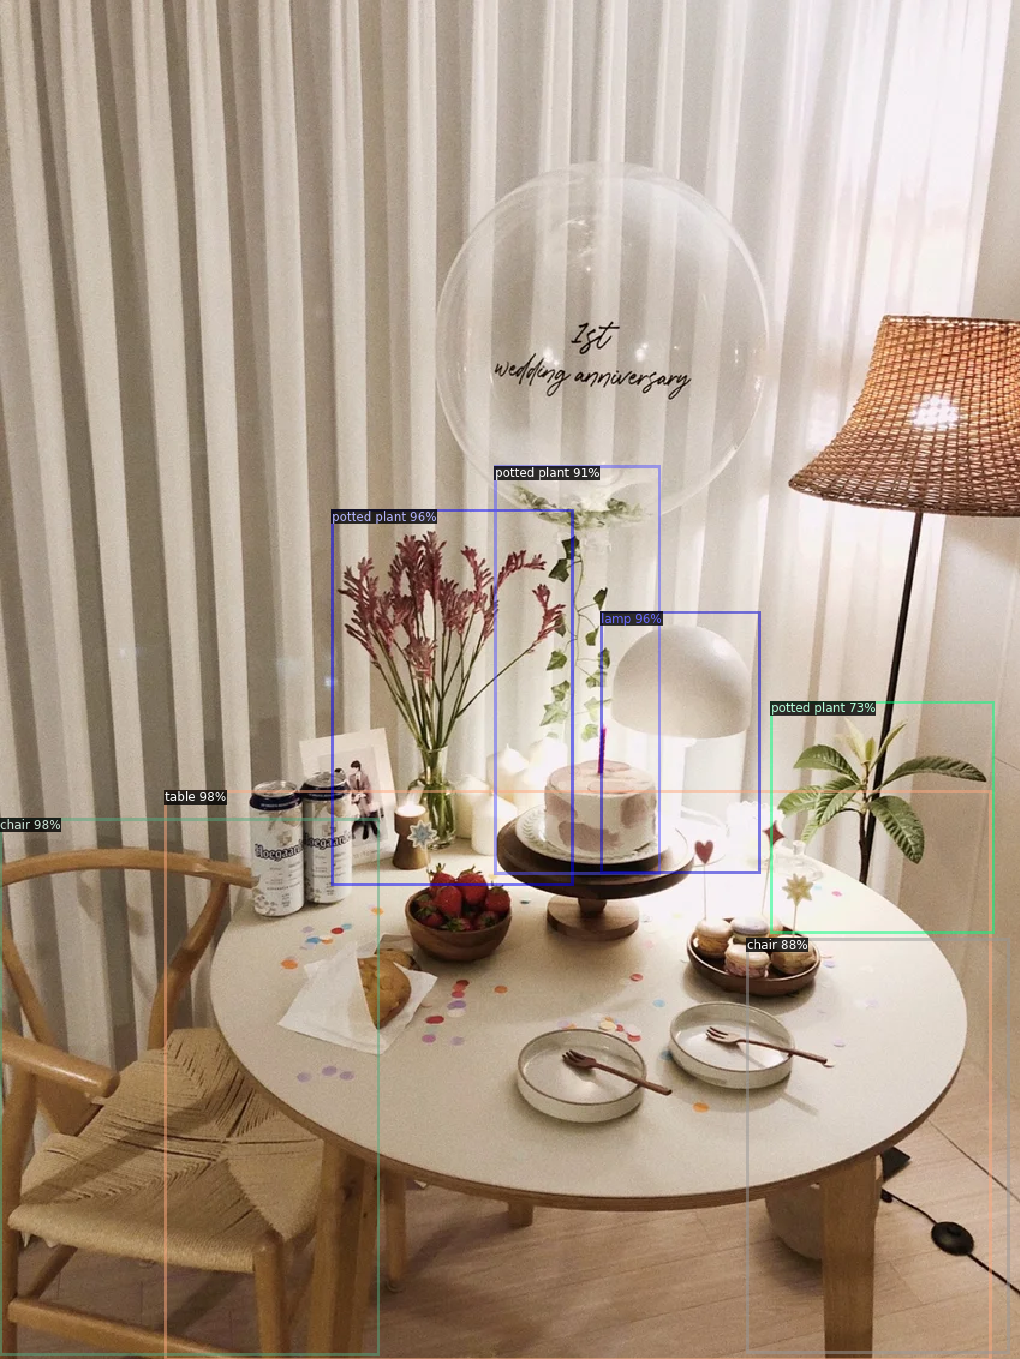

In [15]:
im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/dl_project/test_img.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])